In [1]:
# import pdb
import sys
import common
import argparse
import datasets
import numpy as np
import pandas as pd
import IPython as ip
from tqdm import tqdm, trange
from matplotlib import pyplot as plt
import estimators as estimators_lib
import itertools
import tensorflow as tf
import tensorflow_lattice as tfl

# from LatticeCDF import LatticeCDF, execute_query

In [2]:
def Oracle(table, query):
    cols, idxs, ops, vals = query
    oracle_est = estimators_lib.Oracle(table)

    return oracle_est.Query(cols, ops, vals)


def cal_true_card(query, table):
    cols, idxs, ops, vals = query
    ops = np.array(ops)
    probs = Oracle(table, (cols, idxs, ops, vals))
    return probs


def GenerateQuery(table, min_num_filters, max_num_filters, rng, dataset):
    """Generate a random query."""
    num_filters = rng.randint(max_num_filters - 1, max_num_filters)
    cols, idxs, ops, vals = SampleTupleThenRandom(table, num_filters, rng, dataset)
    sel = cal_true_card((cols, idxs, ops, vals), table) / float(table.cardinality)
    return cols, idxs, ops, vals, sel


def SampleTupleThenRandom(table, num_filters, rng, dataset):
    idxs = rng.choice(len(table.columns), replace=False, size=num_filters)
    cols = np.take(table.columns, idxs)

    # If dom size >= 10, okay to place a range filter.
    # Otherwise, low domain size columns should be queried with equality.
    # ops = rng.choice(['<=', '>=', '='], size=num_filters)
    # ops = rng.choice(['<=', '>'], size=num_filters)
    ops = rng.choice(["<="], size=num_filters)

    #     ops_all_eqs = ['='] * num_filters
    #     sensible_to_do_range = [c.DistributionSize() >= 10 for c in cols]
    #     ops = np.where(sensible_to_do_range, ops, ops_all_eqs)

    # if num_filters == len(table.columns):
    #     return table.columns,np.arange(len(table.columns)), ops, vals

    # vals = vals[idxs]    ## this is fixed to row
    vals = []  ## this will sample in rows
    for i in range(num_filters):
        s = table.data.iloc[rng.randint(0, table.data.shape[0])]
        vals.append(s.values[idxs][i])

    vals = np.array(vals)

    op_a = []
    val_a = []
    for i in range(len(vals)):
        val_a.append([vals[i]])
        op_a.append([ops[i]])

    return cols, idxs, pd.DataFrame(op_a).values, pd.DataFrame(val_a).values

In [3]:
# 修改区间对 > >= < = 均适用
# 修改 初始interval
# 修改空interval使用【1】
# 修改最小值最大值为：0～min， max～max+max-max_2
def dictionary_column_interval(table_size, query_set):
    # Traverse all queries to apply the intervalization skill for each column
    n_column = table_size[1]
    column_interval = {}
    for i in range(n_column):
        column_interval[i] = set()  # use set([0, sys.maxsize]) to adapt '>' and '<'.
    for query in query_set:
        _, col_idxs, _, vals, _ = query
        for i in range(len(col_idxs)):
            column_interval[col_idxs[i]].add(vals[i][0])
    for k, v in column_interval.items():
        if not v:
            column_interval[k] = [0]  # use [0] to represent empty column interval
        else:
            column_interval[k] = sorted(list(v))
    return column_interval

In [4]:
def count_column_unique_interval(unique_intervals):
    # count unique query interval in each column
    return [len(v) for v in unique_intervals.values()]

In [5]:
def execute_query(dataNew, query_set):
    diff = []
    for query in query_set:
        sentence = ""
        for i in range(len(query[0])):
            if i != 0:
                sentence += " and "
            sentence += f"col_{query[1][i]}"
            if query[2][i][0] == "=":
                sentence += "=="
            else:
                sentence += query[2][i][0]
            sentence += f"{query[3][i][0]}"
        sel = dataNew.query(sentence).shape[0] / dataNew.shape[0]
        sel2 = query[4]  # round(query[4] * n_row)
        if sel == 0:
            sel += 1 / dataNew.shape[0]
        if sel2 == 0:
            sel2 += 1 / n_row
        if sel < sel2:
            diff.append(sel2 / sel)
        else:
            diff.append(sel / sel2)
    return diff

In [6]:
def print_error(diff, args):
    print(
        f"\n\n Q-error of Lattice (dataset={args.dataset}, query size={args.query_size}, condition={args.num_conditions}):\n"
    )
    print(f"min:    {np.min(diff)}")
    print(f"10:     {np.percentile(diff, 10)}")
    print(f"20:     {np.percentile(diff, 20)}")
    print(f"30:     {np.percentile(diff, 30)}")
    print(f"40:     {np.percentile(diff, 40)}")
    print(f"median: {np.median(diff)}")
    print(f"60:     {np.percentile(diff, 60)}")
    print(f"70:     {np.percentile(diff, 70)}")
    print(f"80:     {np.percentile(diff, 80)}")
    print(f"90:     {np.percentile(diff, 90)}")
    print(f"95:     {np.percentile(diff, 95)}")
    print(f"99:     {np.percentile(diff, 99)}")
    print(f"max:    {np.max(diff)}")
    print(f"mean:   {np.mean(diff)}")

In [7]:
class LatticeCDF:
    def __init__(
        self,
        name,
        n_row,
        unique_intervals,
        pwl_keypoints=None,  # also can input table unique values
        lattice_size=2,
        l2=1e-2,
    ):

        self.l2 = l2
        self.name = name
        self.n_row = n_row
        self.dim = len(unique_intervals.keys())
        self.lattice_size = lattice_size
        self.unique_intervals = unique_intervals
        self.pwl_calibration_input_keypoints = (
            unique_intervals if pwl_keypoints is None else pwl_keypoints
        )
        self.sample_feat = None

        self.model_inputs = []
        for i in range(self.dim):
            self.model_inputs.append(tf.keras.layers.Input(shape=[1], name="col_%s" % i))
            # self.model_inputs.append(
            #     tf.keras.layers.Input(shape=[1], name='col%s_l' % i))
            # self.model_inputs.append(
            #     tf.keras.layers.Input(shape=[1], name='col%s_u' % i))

        self.calibrators = []
        for i in range(self.dim):
            # self.calibrators.append(
            #     tfl.layers.PWLCalibration(
            #         input_keypoints=np.linspace(
            #             feat_mins[i],
            #             feat_maxs[i],
            #             num=pwl_calibration_num_keypoints),
            #         dtype=tf.float32,
            #         output_min=0.0,
            #         output_max=lattice_size - 1.0,
            #         monotonicity='decreasing',
            #     ))
            self.calibrators.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.array(self.pwl_calibration_input_keypoints[i]),
                    # input_keypoints=np.linspace(
                    #     feat_mins[i],
                    #     feat_maxs[i],
                    #     num=pwl_calibration_num_keypoints),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    monotonicity="increasing",
                )
            )

        self.lattice = tfl.layers.Lattice(
            lattice_sizes=[lattice_size] * self.dim,  # (self.dim * 2),
            interpolation="simplex",  # 可以尝试别的插值类型
            monotonicities=["increasing"] * self.dim,  # (self.dim * 2),
            output_min=0.0,
            output_max=1.0,
            name="lattice",
        )

        # self.output1 = tfl.layers.PWLCalibration(
        #     input_keypoints=np.linspace(0.0,
        #                                 np.log(n_row),
        #                                 num=pwl_calibration_num_keypoints),
        #     dtype=tf.float32,
        #     output_min=0.0,
        #     output_max=np.log(n_row),
        #     name='output1_calib',
        # )

        # self.output2 = tfl.layers.PWLCalibration(
        #     input_keypoints=np.linspace(0.0,
        #                                 n_row,
        #                                 num=pwl_calibration_num_keypoints),
        #     dtype=tf.float32,
        #     output_min=0.0,
        #     output_max=n_row,
        #     name='output2_calib',
        # )

        # self.lattice_inputs = []
        # for i in range(self.dim):  # (self.dim) * 2):
        #     self.lattice_inputs.append(self.calibrators[i](
        #         self.model_inputs[i]))
        # self.model_output = self.output2(
        #     tf.keras.backend.exp(
        #         self.output1(self.lattice(self.lattice_inputs))))

        self.lattice_inputs = []
        for i in range(self.dim):  # (self.dim) * 2):
            self.lattice_inputs.append(self.calibrators[i](self.model_inputs[i]))
        self.model_output = self.lattice(self.lattice_inputs)

        self.model = tf.keras.models.Model(
            inputs=self.model_inputs,
            outputs=self.model_output,
        )
        self.model.summary()

    def fit(
        self,
        X,
        y,
        lr=0.01,
        bs=1000,
        epochs=2000,
        reduceLR_factor=0.5,
        reduceLR_patience=20,
        verbose=1,
        loss="MSE",
    ):
        assert X.shape[0] == y.shape[0]
        # assert X.shape[1] == self.dim * 2

        X = X.astype(np.float32)
        y = y.astype(np.float32)

        # for i in range(self.dim):
        #     self.calibrators[i].input_keypoints = compute_quantiles(
        #         X[:, i].ravel(),
        #         num_keypoints=self.pwl_calibration_num_keypoints,
        #     )
        # self.calibrators[i * 2].input_keypoints = compute_quantiles(
        #     X[:, [i * 2, i * 2 + 1]].ravel(),
        #     num_keypoints=self.pwl_calibration_num_keypoints,
        # )
        # self.calibrators[i * 2 + 1].input_keypoints = compute_quantiles(
        #     X[:, [i * 2, i * 2 + 1]].ravel(),
        #     num_keypoints=self.pwl_calibration_num_keypoints,
        # )

        features = [X[:, i] for i in range(X.shape[1])]
        target = y

        lossFunc = tf.keras.losses.mean_squared_logarithmic_error
        if loss == "MAE":
            lossFunc = tf.keras.losses.mean_absolute_error
        if loss == "MSE":
            lossFunc = tf.keras.losses.mean_squared_error
        if loss == "MAPE":
            lossFunc = tf.keras.losses.mean_absolute_percentage_error

        self.model.compile(loss=lossFunc, optimizer=tf.keras.optimizers.Adamax(lr))

        # earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=500, verbose=verbose, mode='min')
        mcp_save = tf.keras.callbacks.ModelCheckpoint(
            "%s.hdf5" % self.name,
            save_best_only=True,
            monitor="loss",
            mode="min",
            save_weights_only=True,
        )
        reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="loss",
            factor=reduceLR_factor,
            patience=reduceLR_patience,
            verbose=verbose,
            epsilon=1e-10,
            mode="min",
        )

        self.model.fit(
            features,
            target,
            epochs=epochs,
            batch_size=bs,
            verbose=1,
            callbacks=[mcp_save, reduce_lr_loss],
        )
        self.model.load_weights("%s.hdf5" % self.name)

    def load(self, name):
        self.model.load_weights("%s.hdf5" % self.name)

    def inference(self, grid):
        # predict and generate table
        assert grid.shape[1] == self.dim
        # df_grid = pd.DataFrame(cart_2, columns=[f'col_{i}' for i in range(n_column)])
        pred = m.model.predict(np.hsplit(grid, self.dim))
        return pred

    def generate(self, grid):
        assert grid.shape[1] == self.dim
        pred = m.model.predict(np.hsplit(grid, self.dim))
        dataNew = pd.DataFrame(
            columns=[f"col_{i}" for i in range(n_column)],
            index=[i for i in range(np.prod(column_interval_number))],
        )

        # generate 一条再query一条，再generate下一条
        count = 0
        for i in trange(grid.shape[0]):
            sentence = ""
            for j in range(grid.shape[1]):
                if j != 0:
                    sentence += " and "
                sentence += f"col_{j}"  # 这里要改
                sentence += " <= "  # 这里也要改
                sentence += f"{grid[i][j]:f}"

            xi = pred[i][0] * n_row - dataNew.query(sentence).shape[0]

            if int(xi) > 0:
                floor = np.floor(xi)
                ceil = np.ceil(xi)
                if floor == ceil:
                    card = int(xi)
                else:
                    card = np.random.choice([floor, ceil], p=[xi - floor, ceil - xi]).astype("int")
                dataNew.iloc[count : count + card, :] = grid[i]
                count += card
        dataNew.dropna(axis=0, how="all", inplace=True)
        return dataNew

In [8]:
parser = argparse.ArgumentParser()
parser.add_argument("--dataset", type=str, default="wine2", help="Dataset.")
parser.add_argument("--query-size", type=int, default=1000, help="query size")
parser.add_argument("--num-conditions", type=int, default=2, help="num of conditions")
parser.add_argument("--epochs", type=int, default=2000, help="Number of epochs to train for.")
parser.add_argument("--bs", type=int, default=1000, help="Batch size.")
parser.add_argument("--loss", type=str, default="MSE", help="Loss.")
parser.add_argument("--lattice", type=int, default=2, help="Lattice size.")
parser.add_argument("--lr", type=float, default=1e-2, help="learning rate")
parser.add_argument("--seed", type=int, default=4321, help="Random seed")
parser.add_argument("--sample", type=int, default=0, help="reload trained mode")

try:
    args = parser.parse_args()  # for python
except:
    args, unknown = parser.parse_known_args()  # for jupyter notebook

usage: ipykernel_launcher.py [-h] [--dataset DATASET]
                             [--query-size QUERY_SIZE]
                             [--num-conditions NUM_CONDITIONS]
                             [--epochs EPOCHS] [--bs BS] [--loss LOSS]
                             [--lattice LATTICE] [--lr LR] [--seed SEED]
                             [--sample SAMPLE]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/chun/Library/Jupyter/runtime/kernel-v2-54065SfiJlkvnEabl.json


In [9]:
bs = int(args.bs)
lr = float(args.lr)
epochs = int(args.epochs)
lattice = int(args.lattice)
sample = int(args.sample)

type_casts = {}
table = datasets.LoadDataset(args.dataset + ".csv", args.dataset, type_casts=type_casts)
table_train = table
train_data = common.TableDataset(table_train)
query_set = None
print("Begin Generating Queries ...")
rng = np.random.RandomState(args.seed)
query_set = [
    GenerateQuery(table, 2, args.num_conditions + 1, rng, args.dataset)
    for i in trange(args.query_size)
]
print("Complete Generating Queries.")

load dataset wine2.csv done
(6497, 2)
(6497, 2)
0
1
0 106
1 187
[31 36]
(6497, 2)
Begin Generating Queries ...


100%|██████████| 1000/1000 [00:00<00:00, 2728.97it/s]

Complete Generating Queries.


In [10]:
table_size = table.data.shape
n_row = table_size[0]
n_column = table_size[1]
unique_intervals = dictionary_column_interval(table_size, query_set)
# total_intervals, column_interval_number, column_to_variable = count_column_unique_interval(unique_intervals)
column_interval_number = count_column_unique_interval(unique_intervals)

In [11]:
column_interval_number

[75, 109]

In [12]:
# 修改 x = [sys.maxsize] * n_column     # 这里使用每个col_unique_interval的最后一个元素即可
# 如果使用两个input的话，一个修改为最大，一个修改为最小
train_X = []
train_Y = []
for query in query_set:
    x = [sys.maxsize] * n_column  # 这里使用每个col_unique_interval的最后一个元素即可
    _, col_idxs, _, vals, sel = query
    for i in range(len(col_idxs)):
        x[col_idxs[i]] = vals[i][0]
    train_X.append(x)
    train_Y.append(sel)

train_X = np.array(train_X).astype(np.float32)
train_Y = np.array(train_Y).astype(np.float32).reshape(-1, 1)

# make Train set unique
train = np.concatenate((train_X, train_Y), axis=1)
train = np.unique(train, axis=0)
train_X, train_Y = np.hsplit(train, [-1])

In [13]:
m = LatticeCDF(args.dataset + "_" + args.loss, n_row, unique_intervals, pwl_keypoints=None)

2024-06-13 03:14:12.295071: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-06-13 03:14:12.295096: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-13 03:14:12.295103: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-13 03:14:12.295133: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-13 03:14:12.295148: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 col_0 (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 col_1 (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 pwl_calibration (PWLCalibr  (None, 1)                    75        ['col_0[0][0]']               
 ation)                                                                                           
                                                                                                  
 pwl_calibration_1 (PWLCali  (None, 1)                    109       ['col_1[0][0]']           

In [14]:
m.fit(train_X, train_Y, lr=lr, bs=bs, epochs=epochs, loss=args.loss)

Epoch 1/2000


2024-06-13 03:14:13.272674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.0267 - lr: 0.0100
Epoch 2/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.0778 - lr: 0.0100
Epoch 3/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.0272 - lr: 0.0100
Epoch 4/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.0225 - lr: 0.0100
Epoch 5/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.0286 - lr: 0.0100
Epoch 6/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.0280 - lr: 0.0100
Epoch 7/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.0227 - lr: 0.0100
Epoch 8/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.0164 - lr: 0.0100
Epoch 9/2000
1/1 [==============================] - 0s 54ms/step - loss: 0.0136 - lr: 0.0100
Epoch 10/2000
1/1 [==============================] - 0s 54ms/step - loss: 0.0138 - lr: 0.0100
Epoch 11/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.0143 - l

In [15]:
# use interval grid to generate
values = [v for v in unique_intervals.values()]
mesh = np.meshgrid(*values)  # 所有unique interval 的笛卡尔积网格
grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)
# pred = m.inference(grid)
# pred
dataNew = m.generate(grid)
print(dataNew.shape)
diff = execute_query(dataNew, query_set)
print_error(diff, args)

256/256 [==============================] - 1s 4ms/step


100%|██████████| 8175/8175 [00:07<00:00, 1117.55it/s]


(8175, 2)
256/256 [==============================] - 1s 3ms/step


100%|██████████| 8175/8175 [00:07<00:00, 1133.06it/s]




 Q-error of Lattice (dataset=wine2, query size=1000, condition=2):

min:    1.0008285222090367
10:     1.2436521521445238
20:     1.4437777777777778
30:     1.7254602015918143
40:     2.102588996763754
median: 2.744832066330592
60:     4.172385321100917
70:     6.327530553183999
80:     17.125424349742403
90:     75.49638294597506
95:     335.32976758503867
99:     743.8029475142371
max:    937.4134215791903
mean:   45.901161692157046


In [16]:
# use Train set to generate
dataNew = m.generate(train_X)
print(dataNew.shape)
diff = execute_query(dataNew, query_set)
print_error(diff, args)

24/24 [==============================] - 0s 6ms/step


100%|██████████| 753/753 [00:00<00:00, 1341.19it/s]

(7693, 2)
 1/24 [>.............................] - ETA: 0s

24/24 [==============================] - 0s 4ms/step


100%|██████████| 753/753 [00:00<00:00, 1073.81it/s]




 Q-error of Lattice (dataset=wine2, query size=1000, condition=2):

min:    1.000736896458171
10:     1.0422059135257147
20:     1.0787473580805973
30:     1.1076156384919618
40:     1.1450894025015452
median: 1.1869942051785929
60:     1.252282547835595
70:     1.3482225229013112
80:     1.5627143736435376
90:     3.378150548847976
95:     6.744696502532703
99:     24.905339077889444
max:    91.20739852159254
mean:   2.37255148743592


## Lattice

In [17]:
# 对比，对query做unique 和 不做unique的误差

In [18]:
# 对比传入table unique value 和 只传入 unique_intervals的模型优化效果

In [19]:
# table unique value
data = table.data.to_numpy()
unique_vals = []
for i in range(data.shape[1]):
    unique_vals.append(np.unique(data[:, i]))

In [20]:
unique_vals

[array([ 3.8 ,  3.9 ,  4.2 ,  4.4 ,  4.5 ,  4.6 ,  4.7 ,  4.8 ,  4.9 ,
         5.  ,  5.1 ,  5.2 ,  5.3 ,  5.4 ,  5.5 ,  5.6 ,  5.7 ,  5.8 ,
         5.9 ,  6.  ,  6.1 ,  6.15,  6.2 ,  6.3 ,  6.4 ,  6.45,  6.5 ,
         6.6 ,  6.7 ,  6.8 ,  6.9 ,  7.  ,  7.1 ,  7.15,  7.2 ,  7.3 ,
         7.4 ,  7.5 ,  7.6 ,  7.7 ,  7.8 ,  7.9 ,  8.  ,  8.1 ,  8.2 ,
         8.3 ,  8.4 ,  8.5 ,  8.6 ,  8.7 ,  8.8 ,  8.9 ,  9.  ,  9.1 ,
         9.2 ,  9.3 ,  9.4 ,  9.5 ,  9.6 ,  9.7 ,  9.8 ,  9.9 , 10.  ,
        10.1 , 10.2 , 10.3 , 10.4 , 10.5 , 10.6 , 10.7 , 10.8 , 10.9 ,
        11.  , 11.1 , 11.2 , 11.3 , 11.4 , 11.5 , 11.6 , 11.7 , 11.8 ,
        11.9 , 12.  , 12.1 , 12.2 , 12.3 , 12.4 , 12.5 , 12.6 , 12.7 ,
        12.8 , 12.9 , 13.  , 13.2 , 13.3 , 13.4 , 13.5 , 13.7 , 13.8 ,
        14.  , 14.2 , 14.3 , 15.  , 15.5 , 15.6 , 15.9 ]),
 array([0.08 , 0.085, 0.09 , 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125,
        0.13 , 0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 ,
        0.175, 0.1

## 画图

In [21]:
pred = m.inference(grid)

256/256 [==============================] - 1s 4ms/step


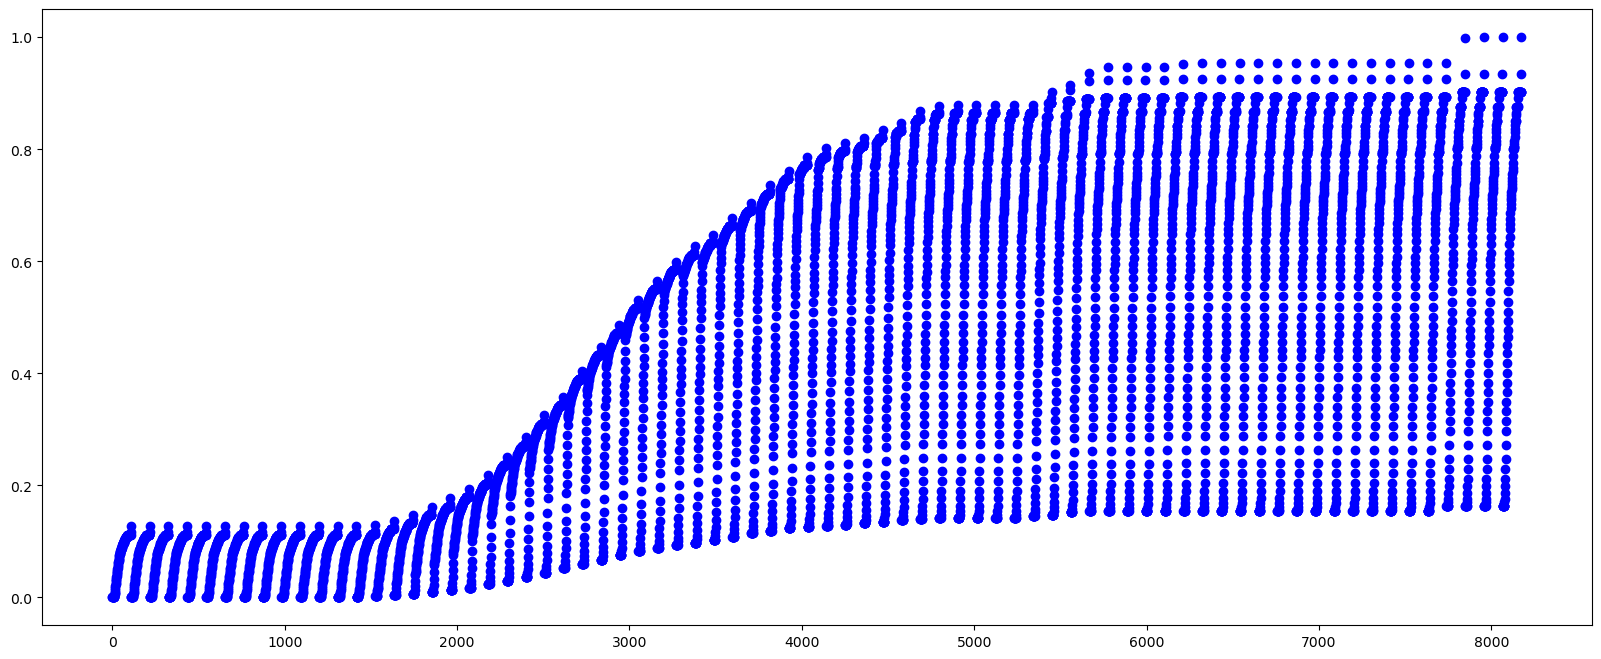

In [22]:
plt.figure(figsize=(20, 8))
plt.plot(pred, "bo")

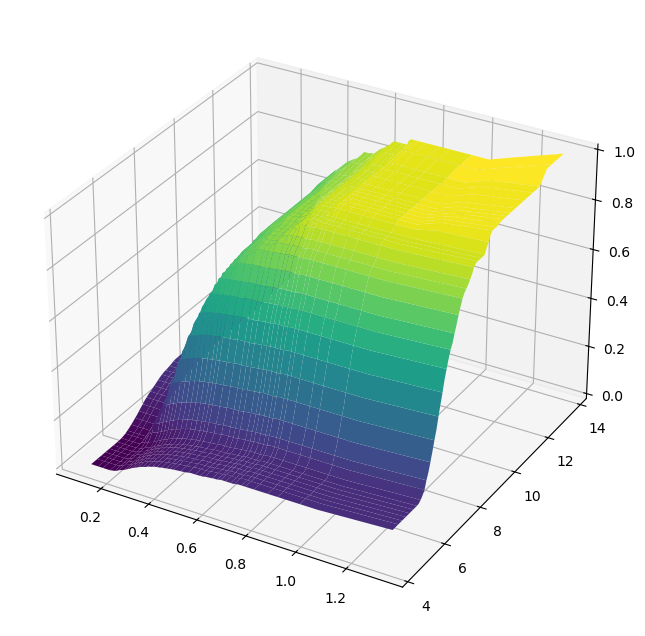

In [23]:
fig1 = plt.figure(figsize=(15, 8))
ax1 = plt.axes(projection="3d")

# xx = unique_intervals[1]
# yy = unique_intervals[0]
# X, Y = np.meshgrid(xx, yy)

X = grid[:, 1].reshape(column_interval_number[0], column_interval_number[1])  # 这样也可以
Y = grid[:, 0].reshape(column_interval_number[0], column_interval_number[1])
Z = pred.reshape(column_interval_number[0], column_interval_number[1])

ax1.plot_surface(X, Y, Z, cmap="viridis")
plt.show()

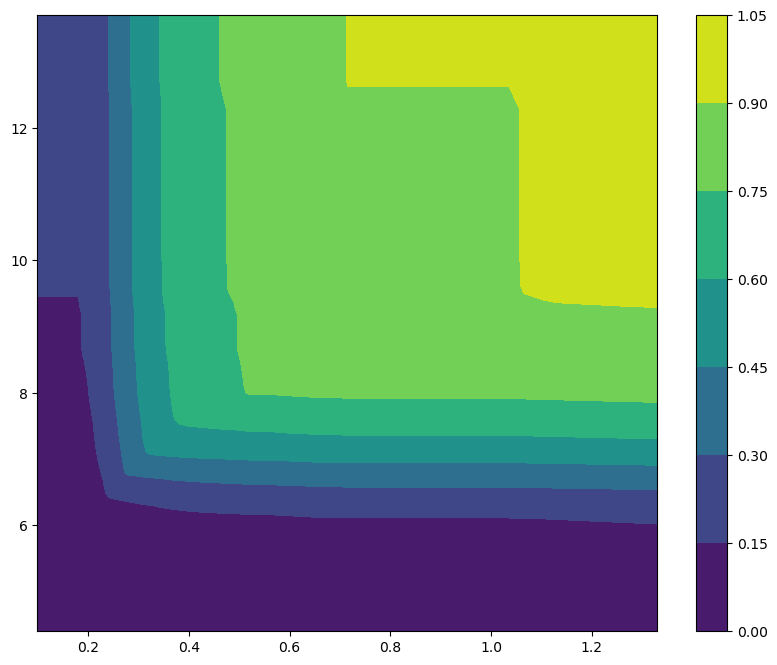

In [24]:
fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(111)
cs = ax2.contourf(X, Y, Z, cmap="viridis")

# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())    # 这个是啥

cbar = fig2.colorbar(cs)  # 让colorbar细粒度更高一点
plt.show()

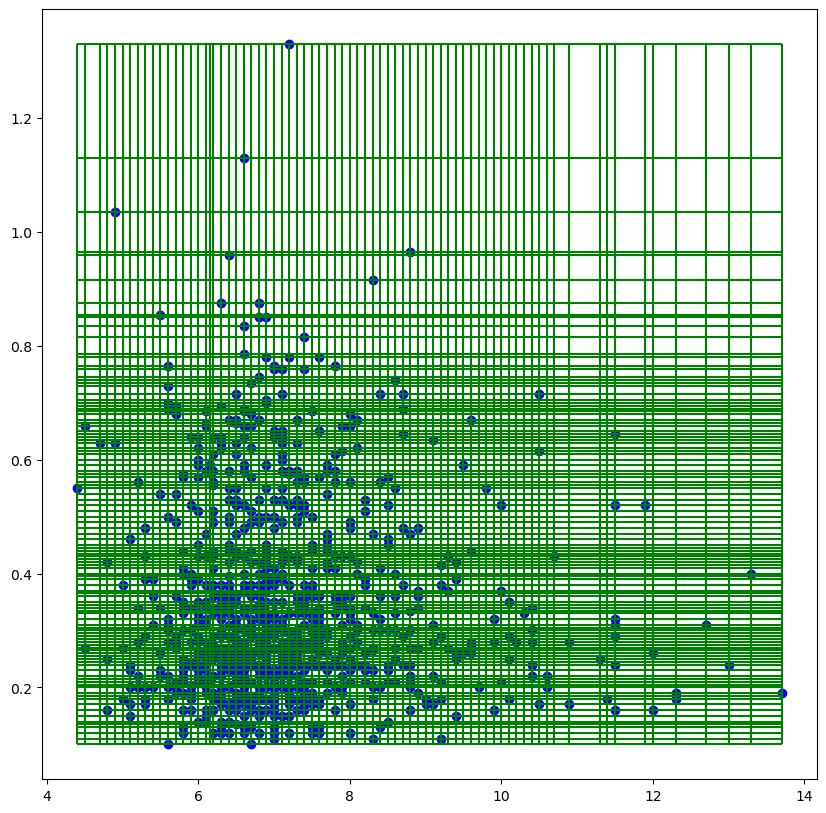

In [25]:
# query 对网格的覆盖率 散点图
fig4 = plt.figure(figsize=(10, 10))
xtick = unique_intervals[0]
ytick = unique_intervals[1]
plt.scatter(train_X[:, 0], train_X[:, 1], c="b")
plt.vlines(xtick, min(ytick), max(ytick), colors="green")
plt.hlines(ytick, min(xtick), max(xtick), colors="green")
plt.show()